In [1]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
# Open data
data_filename = '../data/fainterspectral-fits_6.pickle'
with open(data_filename, 'rb') as f:
    ret = pickle.load(f, encoding="latin1")

# In this tutorial just use data from one wavelength band 
band = 0

#### Look at the observed spectrum (and filtered)

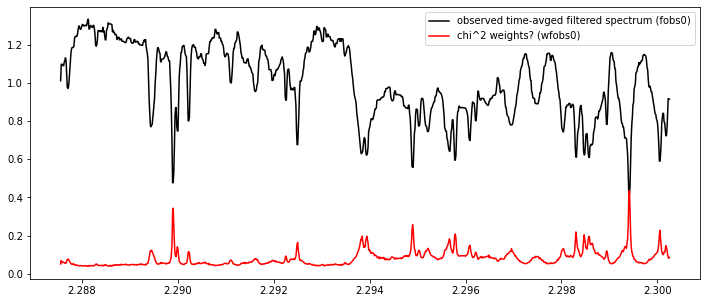

In [65]:
obs0 = np.median(ret['obs0'], axis=0)*14.  # time-avged spectrum, 4*1024, equivalent to summed over 14 timeframes
fobs0 = np.vstack([signal.medfilt(obs0[band], 3) for band in range(4)]) # fobs = filtered obs using a 3-datapoint window
fobs0 = fobs0 / np.median(fobs0, axis=1).reshape(4,1) # normalize flux wrt continuum level(aka. medium over whole band)

eobs0 = np.median(ret['obs0'], axis=0)*np.sqrt(14.) # TODO: what does eobs mean?
eobs0 = eobs0 / np.median(fobs0, 1).reshape(4,1) # normalized wrt band medium
wfobs0 = 1./eobs0**2 # TODO: what does wfobs mean: weights of data points

# Plotting just one wl band to show data
fig = plt.figure(figsize=(12,5))
plt.plot(ret['wobs'][band, :], fobs0[band, :], color='black', label="observed time-avged filtered spectrum (fobs0)")
plt.plot(ret['wobs'][band, :], wfobs0[band, :], color='red', label="chi^2 weights? (wfobs0)")
plt.legend()
plt.show()

#### Converting between pixel number and wavelength (the wavelength solution)

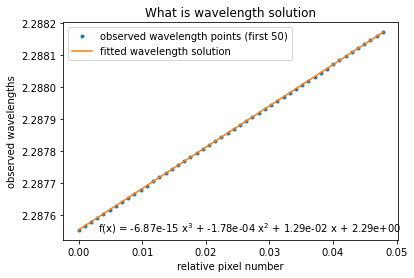

In [4]:
NPW = 4  # NPW = number of wavelength coeffs -> TODO: rename to NUM_WAVELEN_COEFFS
npix = ret['wobs'].shape[1]
pix = np.arange(npix, dtype=float)/npix # 1024 points between [0,1) -> relative pixel number
wcoef = np.polyfit(pix, ret['wobs'][band], NPW-1) # wcoef = wavelength solution coefficients 
func_wavelen_soln = np.poly1d(wcoef)  # wavelength solution = function that convert pix number to wavelength

# Plot first 50 pixels to show relation between pix number and observed wavelength
plt.plot(pix[:50], ret['wobs'][band][:50], ".", label="observed wavelength points (first 50)")
plt.plot(pix[:50], func_wavelen_soln(pix[:50]), "-", label="fitted wavelength solution")
plt.title("What is wavelength solution")
plt.xlabel("relative pixel number")
plt.ylabel("observed wavelengths")
plt.text(0.003, 2.28755, f"f(x) = {wcoef[0]:.2e} x$^3$ + {wcoef[1]:.2e} x$^2$ + {wcoef[2]:.2e} x + {wcoef[3]:.2e}")
plt.legend()
plt.show()

#### Read the template (aka model) BD spectra from BT-Settl library

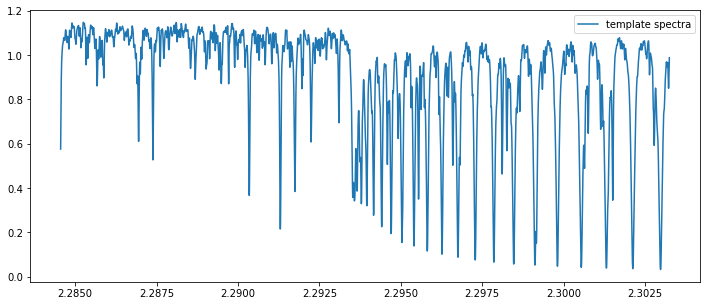

In [5]:
# Open model
from astropy.table import Table
model_filename = '../data/BT-Settl_lte015-5.0-0.0+0.0_orig.fits'
model = Table.read(model_filename, format='fits')
model['wl'] = model['Wavelength']
model['flux'] = model['Flux']

lowerlim = ret['wobs'][band].min() - 0.003  # TODO: where this value from
upperlim = ret['wobs'][band].max() + 0.003
tind = (model['wl'] > lowerlim) * (model['wl'] < upperlim) # get index of template spec where wl covered by obs
lam_template = model['wl'][tind]
template = model['flux'][tind]
template = template/np.median(template) # normalize flux wrt to template median level in this wl band
ccoef = [-0.1, 1.2/np.median(template)] # continuum coefficients, TODO: why these two values??
NPC = len(ccoef) # TODO: rename -> NUM_CONTINUUM_COEFFS

# Plot template spectrum
plt.figure(figsize=(12,5))
plt.plot(lam_template, template, label="template spectra")
plt.legend()
plt.show()

#### Fit data with template by minimizing chi^2

In [15]:
import modelfitting as mf
parametric_spectrum_func = mf.modelspec_template
fitargs = (parametric_spectrum_func, lam_template, template, NPW, NPC, npix, fobs0[band], wfobs0[band])
guess = np.concatenate(([21, 0.3, 9e-5], wcoef, ccoef)) # TODO: define guess values at first and cite source
fit_result = mf.fmin(
    func=mf.errfunc, 
    x0=guess, 
    args=fitargs, 
    full_output=True, 
    disp=True, 
    maxiter=10000, 
    maxfun=10000
)
bestfit_params = fit_result[0]
print("fitted parameters:", bestfit_params)

Optimization terminated successfully.
         Current function value: 1.622415
         Iterations: 2663
         Function evaluations: 3979
fitted parameters: [ 3.01875883e+01  7.67053957e-01  1.09255314e-04 -6.14327474e-15
 -4.03492803e-04  1.32688037e-02  2.28741526e+00  8.27065433e-02
  1.04368660e+00]


#### Plug in best-fit parameters to compute best-fit spectrum

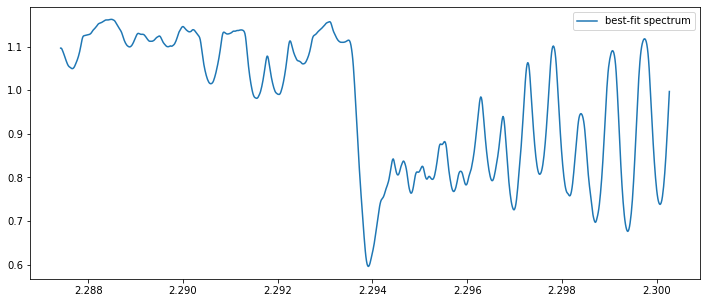

In [27]:
bestfit_spec, bestfit_wl = mf.modelspec_template(bestfit_params, *fitargs[1:-2], retlam=True)
plt.figure(figsize=(12,5))
plt.plot(bestfit_wl, bestfit_spec, label="best-fit spectrum")
plt.legend()
chipmods = np.zeros((4, 1024), dtype=float)
chiplams = np.zeros((4, 1024), dtype=float)
chipmods[band] = bestfit_spec
chiplams[band] = bestfit_wl

#### Compute non-broadened best-fit spectrum

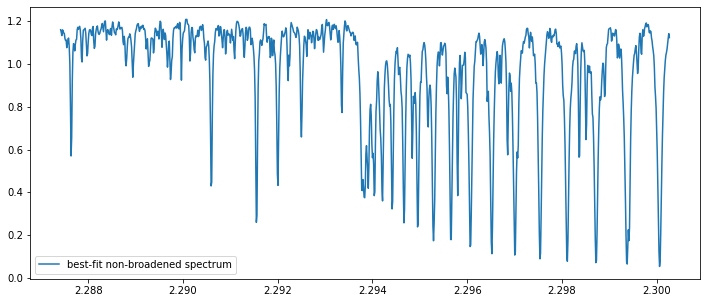

In [28]:
bestfit_params_nobroad = np.concatenate((np.zeros(2), bestfit_params[2:]))
bestfit_spec_nobroad, bestfit_wl_nobroad = mf.modelspec_template(bestfit_params_nobroad, *fitargs[1:-2], retlam=True)
plt.figure(figsize=(12,5))
plt.plot(bestfit_wl_nobroad, bestfit_spec_nobroad, label="best-fit non-broadened spectrum")
plt.legend()
chipmodnobroad = np.zeros((4, 1024), dtype=float)
chipmodnobroad[band] = bestfit_spec_nobroad

#### Plotting all spectra together to compare

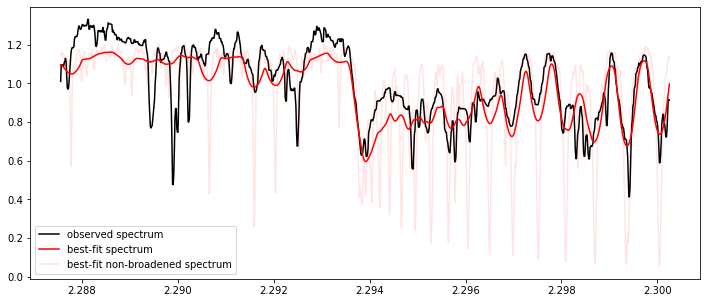

In [38]:
fig = plt.figure(figsize=(12,5))
plt.plot(ret['wobs'][band, :], fobs0[band, :], color='black', label="observed spectrum")
plt.plot(ret['wobs'][band, :], chipmods[band, :], color='red', label="best-fit spectrum")
plt.plot(ret['wobs'][band, :], chipmodnobroad[band, :], color='red', alpha=0.1, label="best-fit non-broadened spectrum")
plt.legend()
plt.show()

#### What is inside the pickle dict

In [64]:
[print(key,":", ret[key].shape) for key in ['wobs0', 'wobs', 'chipmods', 'chiplams', 'obs0', 'obs1', 'chipcors', 'chipmodnobroad']]
print("modelfn :", ret["modelfn"])
print("individual_fits :", np.array(ret["individual_fits"]).shape)

wobs0 : (14, 4, 1024)
wobs : (4, 1024)
chipmods : (14, 4, 1024)
chiplams : (14, 4, 1024)
obs0 : (14, 4, 1024)
obs1 : (14, 4, 1024)
chipcors : (14, 4, 1024)
chipmodnobroad : (14, 4, 1024)
modelfn : /Users/ianc/proj/pcsa/data/model/lte015-5.0-0.0a+0.0.BT-Settl.spec.7.fits
individual_fits : (14, 4, 5)


In [ ]:
# wobs0:           observed wavelengths? (not used)
# wobs:            observed wavelengths
# chipmods:        individual fits?
# chiplams:        ?
# obs0:            observed spectrum, 14 timeframes * 4 bands * 1024 pixels
# obs1:            ? 
# chipcors:        ? 
# chipmodnobroad:  ? 
# individual_fits: 14 * 4 fitted results